# 3. TrainPredict_FineTune
Kaggle score: 0.000

## Run name

In [1]:
import time

project_name = 'Google_LandMark_Rec'
step_name = 'TrainPredict_FineTune'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: Google_LandMark_Rec_TrainPredict_FineTune_20180422_041414


## Important params

In [2]:
image_size = 200
width = height = image_size
target_size = (width, height)
batch_size = 32
epochs = 6

## Import PKGs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display

import os
import gc
import math
import shutil
import zipfile
import pickle
import h5py
from PIL import Image

from tqdm import tqdm
from multiprocessing import cpu_count

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Project folders

In [4]:
cwd = os.getcwd()
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
feature_folder = os.path.join(cwd, 'feature')
post_pca_feature_folder = os.path.join(cwd, 'post_pca_feature')
log_folder = os.path.join(cwd, 'log')
print('input_folder: \t\t\t', input_folder)
print('output_folder: \t\t\t', output_folder)
print('model_folder: \t\t\t', model_folder)
print('feature_folder: \t\t', feature_folder)
print('post_pca_feature_folder: \t', post_pca_feature_folder)
print('log_folder: \t\t\t', log_folder)

org_train_folder = os.path.join(input_folder, 'org_train')
org_test_folder = os.path.join(input_folder, 'org_test')
train_folder = os.path.join(input_folder, 'data_train')
val_folder = os.path.join(input_folder, 'data_val')
test_folder = os.path.join(input_folder, 'data_test')
test_sub_folder = os.path.join(test_folder, 'test')
print('\norg_train_folder: \t\t', org_train_folder)
print('org_test_folder: \t\t', org_test_folder)
print('train_folder: \t\t\t', train_folder)
print('val_folder: \t\t\t', val_folder)
print('test_folder: \t\t\t', test_folder)
print('test_sub_folder: \t\t', test_sub_folder)

if not os.path.exists(post_pca_feature_folder):
    os.mkdir(post_pca_feature_folder)
    print('Create folder: %s' % post_pca_feature_folder)

input_folder: 			 /data1/kaggle/landmark-recognition-challenge/input
output_folder: 			 /data1/kaggle/landmark-recognition-challenge/output
model_folder: 			 /data1/kaggle/landmark-recognition-challenge/model
feature_folder: 		 /data1/kaggle/landmark-recognition-challenge/feature
post_pca_feature_folder: 	 /data1/kaggle/landmark-recognition-challenge/post_pca_feature
log_folder: 			 /data1/kaggle/landmark-recognition-challenge/log

org_train_folder: 		 /data1/kaggle/landmark-recognition-challenge/input/org_train
org_test_folder: 		 /data1/kaggle/landmark-recognition-challenge/input/org_test
train_folder: 			 /data1/kaggle/landmark-recognition-challenge/input/data_train
val_folder: 			 /data1/kaggle/landmark-recognition-challenge/input/data_val
test_folder: 			 /data1/kaggle/landmark-recognition-challenge/input/data_test
test_sub_folder: 		 /data1/kaggle/landmark-recognition-challenge/input/data_test/test


In [5]:
train_csv_file = os.path.join(input_folder, 'train.csv')
test_csv_file = os.path.join(input_folder, 'test.csv')
sample_submission_folder = os.path.join(input_folder, 'sample_submission.csv')

## Get landmark_id set

In [6]:
train_csv = pd.read_csv(train_csv_file)
print('train_csv.shape is {0}.'.format(train_csv.shape))
display(train_csv.head(10))

test_csv = pd.read_csv(test_csv_file)
print('test_csv.shape is {0}.'.format(test_csv.shape))
display(test_csv.head(10))

train_csv.shape is (1225029, 3).


,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231
5,2c9c54b62f0a6a37,https://lh5.googleusercontent.com/-mEaSECO7D-4...,10400
6,0aac70a1de44ced6,http://lh6.ggpht.com/-cJMh9AYQGk8/SOkF_Q5PrjI/...,9779
7,de770bc720f8e714,https://lh4.googleusercontent.com/-Q_FvRlwaaa8...,11288
8,dc9457d703e612ad,https://lh3.googleusercontent.com/-Px33Q-wekRI...,13170
9,3060f5f75d936abb,http://lh3.ggpht.com/-KXyELwqwp_Q/Ry-qmQAqwUI/...,6051


test_csv.shape is (117703, 2).


,id,url
0,000088da12d664db,https://lh3.googleusercontent.com/-k45wfamuhT8...
1,0001623c6d808702,https://lh3.googleusercontent.com/-OQ0ywv8KVIA...
2,0001bbb682d45002,https://lh3.googleusercontent.com/-kloLenz1xZk...
3,0002362830cfe3a3,https://lh3.googleusercontent.com/-N6z79jNZYTg...
4,000270c9100de789,https://lh3.googleusercontent.com/-keriHaVOq1U...
5,0002b0fab5d3ccc4,https://lh3.googleusercontent.com/-ciWklpsrab8...
6,000396be3c24830a,https://lh3.googleusercontent.com/-6W9F179t59Q...
7,000506dc6ab3a40e,https://lh3.googleusercontent.com/-_XHsAXB2LZA...
8,0005292fc4b005a3,https://lh3.googleusercontent.com/-RBZ4F1ZKNc0...
9,0005456a82264bc8,https://lh3.googleusercontent.com/-MRK7_uiKO6A...


In [7]:
train_id = train_csv['id']
train_landmark_id = train_csv['landmark_id']
unique_landmark_ids = list(set(train_landmark_id))
len_unique_landmark_ids = len(unique_landmark_ids)
print(unique_landmark_ids[:10]) # 确认landmark_id是从0开始
print('len(unique_landmark_ids)=%d' % len_unique_landmark_ids)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
len(unique_landmark_ids)=14951


## Preview sample_submission.csv

In [8]:
sample_submission_csv = pd.read_csv(sample_submission_folder)
print('sample_submission_csv.shape is {0}.'.format(sample_submission_csv.shape))
display(sample_submission_csv.head(2))

sample_submission_csv.shape is (117703, 2).


,id,landmarks
0,000088da12d664db,8815 0.03
1,0001623c6d808702,7249 0.61


## Data Generator

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [10]:
%%time
train_gen = ImageDataGenerator(
    rotation_range=20,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    channel_shift_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='wrap'
)

val_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 40.3 µs


In [11]:
%%time
train_generator = train_gen.flow_from_directory(train_folder, target_size, shuffle=True, batch_size=batch_size)
val_generator = val_gen.flow_from_directory(val_folder, target_size, shuffle=False, batch_size=batch_size)
test_generator = test_gen.flow_from_directory(test_folder, target_size, shuffle=False, batch_size=batch_size)

Found 1193691 images belonging to 14951 classes.
Found 24362 images belonging to 14951 classes.
Found 115619 images belonging to 1 classes.
CPU times: user 1min 54s, sys: 55.6 s, total: 2min 50s
Wall time: 36min 49s


In [12]:
print(train_generator.classes[:10])
print(val_generator.classes[:10])
print(test_generator.classes[:10])

print(train_generator.filenames[:10])
print(val_generator.filenames[:10])
print(test_generator.filenames[:10])

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 3 3 3 3 3 3 5]
[0 0 0 0 0 0 0 0 0 0]
['00000/0439f888c5af0e99.jpg', '00000/05aaa786f5c9e0d1.jpg', '00000/063e56d977e00da1.jpg', '00000/06ac932cbf89ce44.jpg', '00000/126ee1b60065dbd4.jpg', '00000/14d86ba0c00b16d1.jpg', '00000/17a57bb3fa8c2d4e.jpg', '00000/1886e9f023806d4a.jpg', '00000/1f7e7418023935ee.jpg', '00000/22e28089dac709f0.jpg']
['00000/4e8ab93c1620e8a3.jpg', '00000/90187c0b6f3fa112.jpg', '00000/e8f5d139190cf632.jpg', '00003/1ecb7b8fbe3ad95f.jpg', '00003/2a71be02ed724c64.jpg', '00003/2aae948adfc18746.jpg', '00003/61276bb730b3b2ce.jpg', '00003/88effeacfe9d031c.jpg', '00003/deb6b65a01c11ce3.jpg', '00005/0825204942d307da.jpg']
['test/000088da12d664db.jpg', 'test/0001623c6d808702.jpg', 'test/0001bbb682d45002.jpg', 'test/0002362830cfe3a3.jpg', 'test/000270c9100de789.jpg', 'test/0002b0fab5d3ccc4.jpg', 'test/000396be3c24830a.jpg', 'test/000506dc6ab3a40e.jpg', 'test/0005292fc4b005a3.jpg', 'test/0005456a82264bc8.jpg']


In [13]:
steps_per_epoch_train = int(len(train_generator.classes) / batch_size)
steps_per_epoch_val = int(len(val_generator.classes) / batch_size)
print('steps_per_epoch_train=%s' % steps_per_epoch_train)
print('steps_per_epoch_val=%s' % steps_per_epoch_val)

steps_per_epoch_train=37302
steps_per_epoch_val=761


## Build CNN

In [14]:
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.applications import *

In [15]:
%%time

input_tensor = Input((height, width, 3))
input_tensor_preprocess = Lambda(inception_resnet_v2.preprocess_input)(input_tensor)
base_model = InceptionResNetV2(input_tensor=input_tensor_preprocess, weights='imagenet', include_top=False)
# input_tensor_preprocess = Lambda(vgg16.preprocess_input)(input_tensor)
# base_model = VGG16(input_tensor=input_tensor_preprocess, weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(4096, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(len_unique_landmark_ids, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)

for layer in base_model.layers:
    layer.trainable = True
    
model.compile(
    optimizer=Adam(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

CPU times: user 34 s, sys: 0 ns, total: 34 s
Wall time: 34.3 s


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 200, 200, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 99, 32)   864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 99, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [17]:
def get_lr(x):
#     lr = round(3e-4 * 0.96 ** x, 6)
#     if lr < 1e-5:
#         lr = 1e-5
    
    if x < 5:
        lr = 3e-4
    elif x >= 10 and x < 15:
        lr = 1e-4
    elif x >= 15 and x <= 20:
        lr = 5e-5
    else:
        lr = 1e-4
    print(lr, end='  ')
    return lr

for i in range(1, epochs + 1):
    get_lr(i)
    print(i)
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

early_stop = EarlyStopping(monitor='acc', min_delta=0.01, patience=0.005, verbose=0, mode='auto')

log_dir = os.path.join(log_folder, run_name)
print('\nlog_dir: %s' % log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)


callbacks = []
callbacks = [annealer]
# callbacks = [annealer]

0.0003  1
0.0003  2
0.0003  3
0.0003  4
0.0001  5
0.0001  6

log_dir: /data1/kaggle/landmark-recognition-challenge/log/Google_LandMark_Rec_TrainPredict_FineTune_20180422_041414


In [18]:
cpu_amount = cpu_count()
print(cpu_amount)

8


In [19]:
%%time
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=callbacks,
    max_queue_size=batch_size,
    workers=cpu_amount,
    use_multiprocessing=False,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val
)

Epoch 1/6
37302/37302 [==============================] - 17278s 463ms/step - loss: 4.4922 - acc: 0.3272 - val_loss: 2.6534 - val_acc: 0.5570
Epoch 2/6
37302/37302 [==============================] - 17150s 460ms/step - loss: 2.2515 - acc: 0.6051 - val_loss: 1.4645 - val_acc: 0.7361
Epoch 3/6
37302/37302 [==============================] - 17219s 462ms/step - loss: 1.4903 - acc: 0.7169 - val_loss: 0.9957 - val_acc: 0.8133
Epoch 4/6
37302/37302 [==============================] - 17269s 463ms/step - loss: 1.1545 - acc: 0.7674 - val_loss: 0.8235 - val_acc: 0.8380
Epoch 5/6
37302/37302 [==============================] - 17225s 462ms/step - loss: 1.0427 - acc: 0.7834 - val_loss: 0.8232 - val_acc: 0.8364
Epoch 6/6
37302/37302 [==============================] - 17293s 464ms/step - loss: 0.7100 - acc: 0.8464 - val_loss: 0.4859 - val_acc: 0.9014
CPU times: user 8d 8h 41min 46s, sys: 2h 6min 29s, total: 8d 10h 48min 16s
Wall time: 1d 4h 44min 14s


In [20]:
%%time
final_loss, final_acc = model.evaluate_generator(
    val_generator,
    max_queue_size=batch_size,
    workers=cpu_amount,
    use_multiprocessing=False,
    steps=steps_per_epoch_val
)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.4859, final accuracy: 0.9014
CPU times: user 32min 18s, sys: 10 s, total: 32min 28s
Wall time: 4min 8s


In [21]:
run_name_acc = run_name + '_' + str(int(final_acc*10000)).zfill(4)
print(run_name_acc)

Google_LandMark_Rec_TrainPredict_FineTune_20180422_041414_9013


In [22]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_folder, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


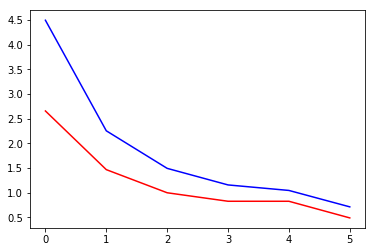

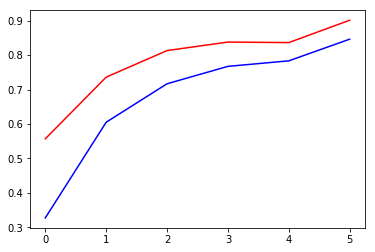

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [24]:
def save_network(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
save_network(model, run_name_acc)

## Predict

In [25]:
train_generator = train_gen.flow_from_directory(train_folder, target_size, shuffle=False, batch_size=batch_size)
train_generator.classes[:10]

Found 1193691 images belonging to 14951 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [26]:
%%time
y_val_proba = model.predict_generator(
    val_generator,
    max_queue_size=128,
    workers=cpu_amount,
    use_multiprocessing=True
)
print(y_val_proba.shape)

(24362, 14951)
CPU times: user 1min, sys: 11.1 s, total: 1min 11s
Wall time: 4min 12s


In [27]:
%%time
y_test_proba = model.predict_generator(
    test_generator,
    max_queue_size=128,
    workers=cpu_amount,
    use_multiprocessing=True
)
print(y_test_proba.shape)

(115619, 14951)
CPU times: user 5min 10s, sys: 59.8 s, total: 6min 10s
Wall time: 22min 33s


In [28]:
# 这里证明os.listdir()得到的图片名称list不正确
files = os.listdir(os.path.join(test_folder, 'test'))
print(files[:10])

# 这里证明ImageDataGenerator()得到的图片名称list才是正确
# gen = ImageDataGenerator()
# image_size = (299, 299)
# test_generator  = gen.flow_from_directory(test_folder, image_size, shuffle=False, batch_size=batch_size)
print('test_generator')
print(len(test_generator.filenames))
print(test_generator.filenames[:10])

['3d8d7d0946abc715.jpg', '48f52f2d6ac1ce30.jpg', '97ab0a1fc0daa989.jpg', '4eeb84778091b5b7.jpg', '5dbec2f259f0b1c2.jpg', '34cf94fc2efe98fd.jpg', '6e7bbdba8fa50888.jpg', '6a94b08945a2e4d1.jpg', '523fc13eb177459b.jpg', '92e13dc918c7479d.jpg']
test_generator
115619
['test/000088da12d664db.jpg', 'test/0001623c6d808702.jpg', 'test/0001bbb682d45002.jpg', 'test/0002362830cfe3a3.jpg', 'test/000270c9100de789.jpg', 'test/0002b0fab5d3ccc4.jpg', 'test/000396be3c24830a.jpg', 'test/000506dc6ab3a40e.jpg', 'test/0005292fc4b005a3.jpg', 'test/0005456a82264bc8.jpg']


In [29]:
def save_proba(y_val_proba, y_val, y_test_proba, test_filenames, file_name):
    test_filenames = [n.encode('utf8') for n in test_filenames]
    print(test_filenames[:10])
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: \t%s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('y_val_proba', data=y_val_proba)
        h.create_dataset('y_val', data=y_val)
        h.create_dataset('y_test_proba', data=y_test_proba)
        h.create_dataset('test_filenames', data=test_filenames)
    print('File saved: \t%s' % file_name)

def load_proba(file_name):
    with h5py.File(file_name, 'r') as h:
        y_val_proba = np.array(h['y_val_proba'])
        y_val = np.array(h['y_val'])
        y_test_proba = np.array(h['y_test_proba'])
        test_filenames = np.array(h['test_filenames'])
    print('File loaded: \t%s' % file_name)
    test_filenames = [n.decode('utf8') for n in test_filenames]
    print(test_filenames[:10])
    
    return y_val_proba, y_val, y_test_proba, test_filenames


y_proba_file = os.path.join(model_folder, 'proba_%s.p' % run_name_acc)
save_proba(y_val_proba, val_generator.classes, y_test_proba, test_generator.filenames, y_proba_file)
y_val_proba, y_val, y_test_proba, test_filenames = load_proba(y_proba_file)


print(y_val_proba.shape)
print(y_val.shape)
print(y_test_proba.shape)
print(len(test_filenames))

[b'test/000088da12d664db.jpg', b'test/0001623c6d808702.jpg', b'test/0001bbb682d45002.jpg', b'test/0002362830cfe3a3.jpg', b'test/000270c9100de789.jpg', b'test/0002b0fab5d3ccc4.jpg', b'test/000396be3c24830a.jpg', b'test/000506dc6ab3a40e.jpg', b'test/0005292fc4b005a3.jpg', b'test/0005456a82264bc8.jpg']
File saved: 	/data1/kaggle/landmark-recognition-challenge/model/proba_Google_LandMark_Rec_TrainPredict_FineTune_20180422_041414_9013.p
File loaded: 	/data1/kaggle/landmark-recognition-challenge/model/proba_Google_LandMark_Rec_TrainPredict_FineTune_20180422_041414_9013.p
['test/000088da12d664db.jpg', 'test/0001623c6d808702.jpg', 'test/0001bbb682d45002.jpg', 'test/0002362830cfe3a3.jpg', 'test/000270c9100de789.jpg', 'test/0002b0fab5d3ccc4.jpg', 'test/000396be3c24830a.jpg', 'test/000506dc6ab3a40e.jpg', 'test/0005292fc4b005a3.jpg', 'test/0005456a82264bc8.jpg']
(24362, 14951)
(24362,)
(115619, 14951)
115619


In [35]:
%%time
max_indexes = np.argmax(y_test_proba, -1)
print(max_indexes.shape)

test_dict = {}
for i, paire in enumerate(zip(test_generator.filenames, max_indexes)):
    image_name, indx = paire[0], paire[1]
    image_id = image_name[5:-4]
#     test_dict[image_id] = '%d %.4f' % (indx, y_pred[i, indx])
    test_dict[image_id] = '%d %.4f' % (indx, 1)

#确认图片的id是否能与ImageDataGenerator()对应上
for key in list(test_dict.keys())[:10]:
    print('%s  %s' % (key, test_dict[key]))

(115619,)
000088da12d664db  13548 1.0000
0001623c6d808702  4330 1.0000
0001bbb682d45002  9099 1.0000
0002362830cfe3a3  9738 1.0000
000270c9100de789  11846 1.0000
0002b0fab5d3ccc4  11139 1.0000
000396be3c24830a  9618 1.0000
000506dc6ab3a40e  11619 1.0000
0005292fc4b005a3  5954 1.0000
0005456a82264bc8  3831 1.0000
CPU times: user 1.56 s, sys: 4 ms, total: 1.56 s
Wall time: 1.53 s


In [36]:
display(sample_submission_csv.head(2))

,id,landmarks
0,000088da12d664db,8815 0.03
1,0001623c6d808702,7249 0.61


In [37]:
%%time
len_sample_submission_csv = len(sample_submission_csv)
print('len(len_sample_submission_csv)=%d' % len_sample_submission_csv)
count = 0
for i in range(len_sample_submission_csv):
    image_id = sample_submission_csv.iloc[i, 0]
#     landmarks = sample_submission_csv.iloc[i, 1]
    if image_id in test_dict:
        pred_landmarks = test_dict[image_id]
#         print('%s  %s' % (image_id, pred_landmarks))
        sample_submission_csv.iloc[i, 1] = pred_landmarks
    else:
#         print(image_id)
        sample_submission_csv.iloc[i, 1] = '9633 1.0' # 属于9633的类最多，所以全都设置成这个类，可能会比设置成空得到的结果好
#         sample_submission_csv.iloc[i, 1] = '' # 设置成空
    count += 1
    if count % 10000 == 0:
        print(int(count/10000), end=' ')
display(sample_submission_csv.head(2))

len(len_sample_submission_csv)=117703
1 2 3 4 5 6 7 8 9 10 11 

,id,landmarks
0,000088da12d664db,13548 1.0000
1,0001623c6d808702,4330 1.0000


CPU times: user 8min 7s, sys: 32 ms, total: 8min 7s
Wall time: 8min 2s


In [38]:
pred_file = os.path.join(output_folder, 'pred_' + run_name_acc + '.csv')
sample_submission_csv.to_csv(pred_file, index=None)

In [39]:
print('Time cost: %.2f' % (time.time() - t0))

print(run_name_acc)
print('Done !')

Time cost: 113875.02
Google_LandMark_Rec_TrainPredict_FineTune_20180422_041414_9013
Done !
